In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize]

# Train binary classification

## Data

In [4]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv', dtype={'GASS': str, 'lgGF': float})
df.shape

(1179, 42)

In [5]:
# get only very gas-rich or gas-poor
df = df[(df.lgGF > -0.75) | (df.lgGF < -1.25)]
df.shape

(918, 42)

In [6]:
# assign binary class
df['gas_rich'] = np.where(df.lgGF > -0.75, True, False)

In [7]:
(~df.gas_rich).sum(), df.gas_rich.sum()

(518, 400)

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['gas_rich'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

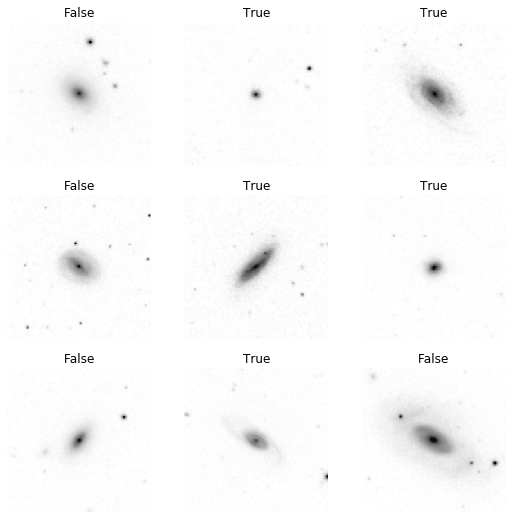

In [9]:
dls.show_batch()

## xresnet9

In [42]:
learn = Learner(
    dls, 
    XResNet(ResBlock, 1, [1,1,1,1], c_in=1, n_out=2, stem_szs=[24, 32, 64], sa=True, act_cls=MishCuda),
    metrics=accuracy,
    opt_func=ranger,
)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.9120108485221863)

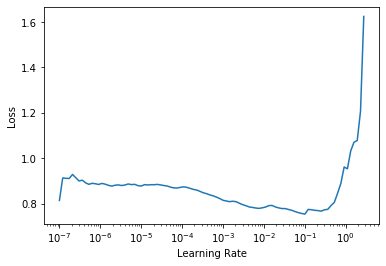

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(20, 3e-3, pct_start=0.5)

## Grad-CAM

In [46]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()



class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()


In [47]:
dls.vocab # 0 -> False, 1 -> True

(#2) [False,True]

### Gas-rich predictions

In [48]:
x,y = next(iter(dls.valid_ds))

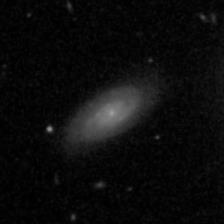

In [49]:
x

In [80]:
cls = 1
with HookBwd(learn.model[7]) as hookg:
    with Hook(learn.model[7]) as hook:
        output = learn.model.eval()(tensor(x).unsqueeze(0).unsqueeze(0).float().cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


In [82]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

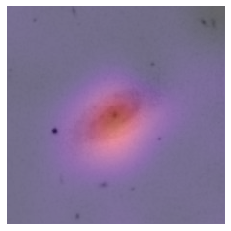

In [95]:

_,ax = plt.subplots()
plt.imshow(x, cmap='Greys')
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bicubic', cmap='magma_r');
plt.axis('off');

### Gas-poor

In [96]:
cls = 0
with HookBwd(learn.model[7]) as hookg:
    with Hook(learn.model[7]) as hook:
        output = learn.model.eval()(tensor(x).unsqueeze(0).unsqueeze(0).float().cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

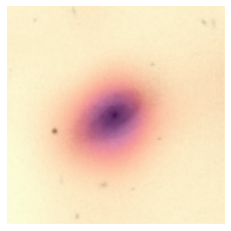

In [97]:

_,ax = plt.subplots()
plt.imshow(x, cmap='Greys')
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bicubic', cmap='magma_r');
plt.axis('off');

# Use simpler CNN (and more spread-out classes)

In [4]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv', dtype={'GASS': str, 'lgGF': float})
df = df[(df.lgGF > -0.5) | (df.lgGF < -1.5)]

df['gas_rich'] = np.where(df.lgGF > -0.5, True, False)

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['gas_rich'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [69]:
# custom model
model = SimpleCNN(filters=[1, 32, 64, 128], kernel_szs=[9,7,5], strides=[5,4,3],) # this works well (~90% accuracy), but is too coarse resolution
model[-1] = nn.Sequential(
    *model[-1],
    nn.Linear(in_features=64, out_features=2)
)

In [70]:
learn = Learner(
    dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.0964781722577754e-06)

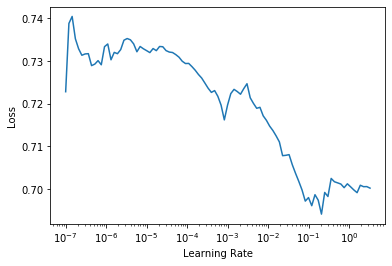

In [71]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(20, 1e-2)

## Resnet-like model

In [152]:
model = XResNet(ResBlock, 1, [2,2], c_in=1, n_out=2, stem_szs=[16, 32, 64])
model[-1] = nn.Linear(in_features=128, out_features=2)
learn = Learner(
    dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.013182567432522774)

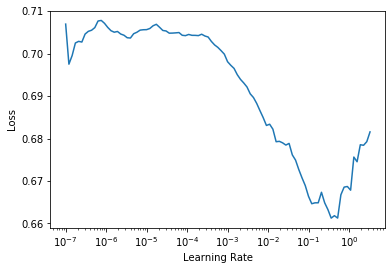

In [153]:
learn.lr_find()

In [154]:
learn.fit_flat_cos(20, 1e-2)

## Grad-CAM

In [155]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()



class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()


In [156]:
xb, yb = next(iter(dls.valid))

In [264]:
def plot_gradcam(xb, idx, hooked_layer=learn.model[5][-1]):

    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    for i, ax in zip([0, 1, 2], axes):

        if i == 0:
            ax.imshow(xb[idx][0].cpu(), cmap='Greys_r')
            ax.axis('off');
            continue

        with HookBwd(hooked_layer) as hookg:
            with Hook(hooked_layer) as hook:
                output = learn.model.eval()(xb[idx].unsqueeze(0))
                act = hook.stored
            output[0,i-1].backward()
            grad = hookg.stored
            print(output)

            w = grad[0].mean(dim=[1,2], keepdim=True)
            cam_map = (w * act[0]).sum(0).detach().cpu()
            
            cam_map = np.where(cam_map > 0, cam_map, 0)

            ax.imshow(xb[idx][0].cpu(), cmap='Greys_r')
            ax.imshow(cam_map, alpha=0.6, extent=(0,224,224,0),
                          interpolation='bicubic', cmap='inferno');
            ax.axis('off');
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    


tensor([[-1.2394,  1.3039]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-1.2394,  1.3039]], device='cuda:0', grad_fn=<AddmmBackward>)


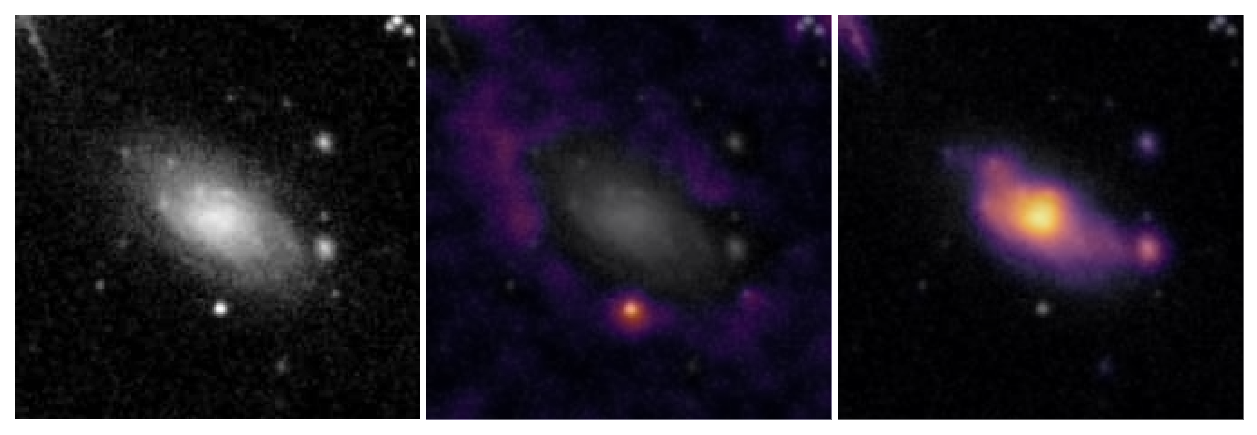

tensor([[ 0.8390, -0.7810]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.8390, -0.7810]], device='cuda:0', grad_fn=<AddmmBackward>)


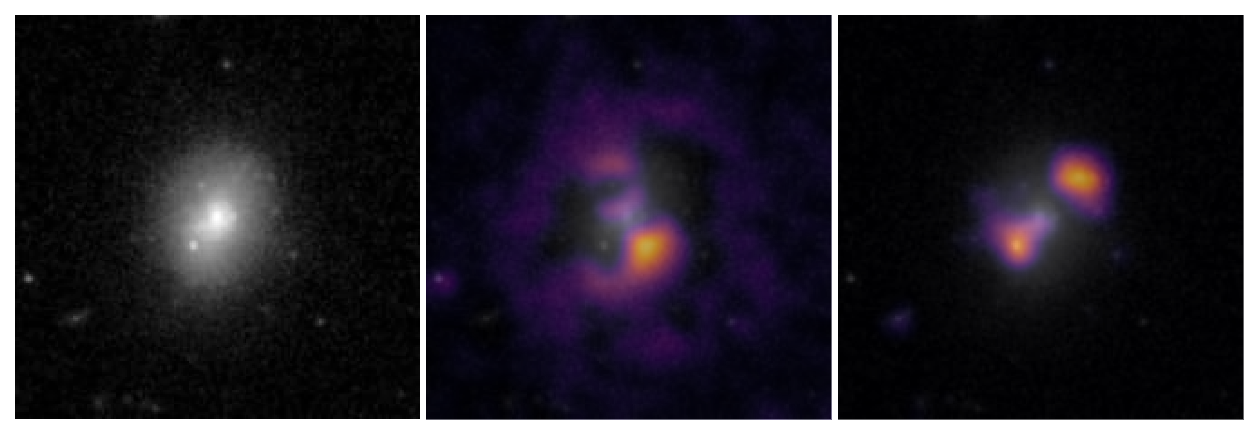

tensor([[ 0.9813, -1.0182]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.9813, -1.0182]], device='cuda:0', grad_fn=<AddmmBackward>)


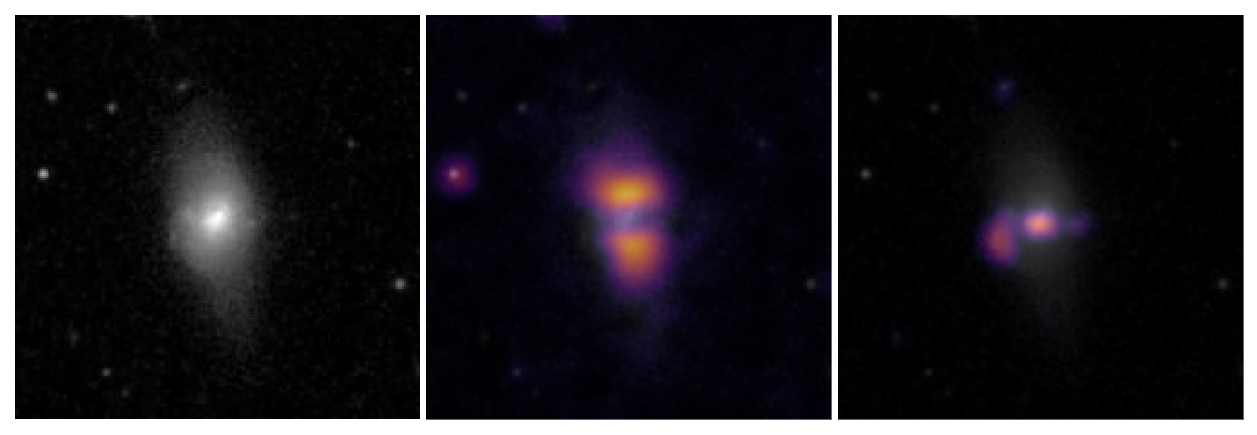

tensor([[ 0.6241, -0.6934]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.6241, -0.6934]], device='cuda:0', grad_fn=<AddmmBackward>)


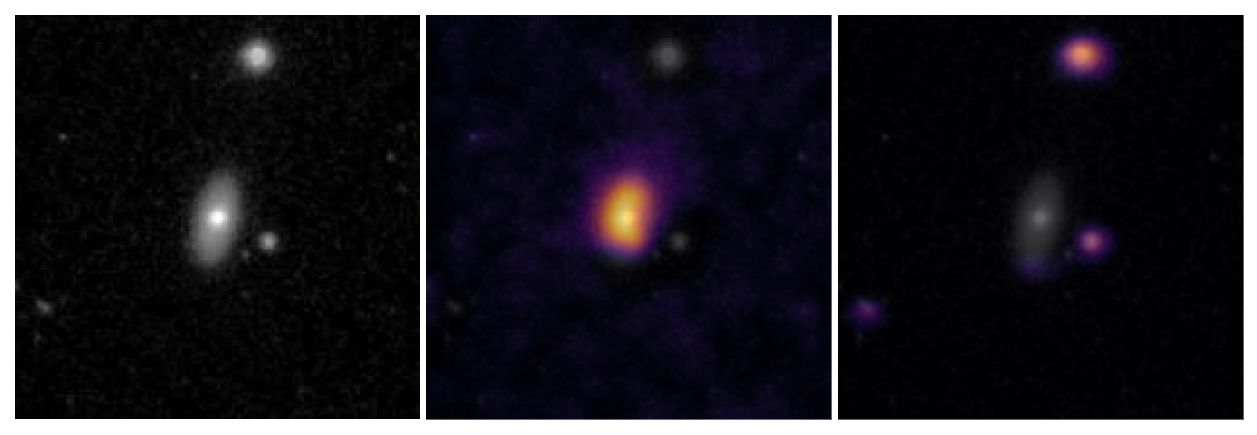

In [267]:
for i in range(6, 10):
    plot_gradcam(xb, i)

tensor([[-6.6945,  7.5992]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-6.6945,  7.5992]], device='cuda:0', grad_fn=<AddmmBackward>)


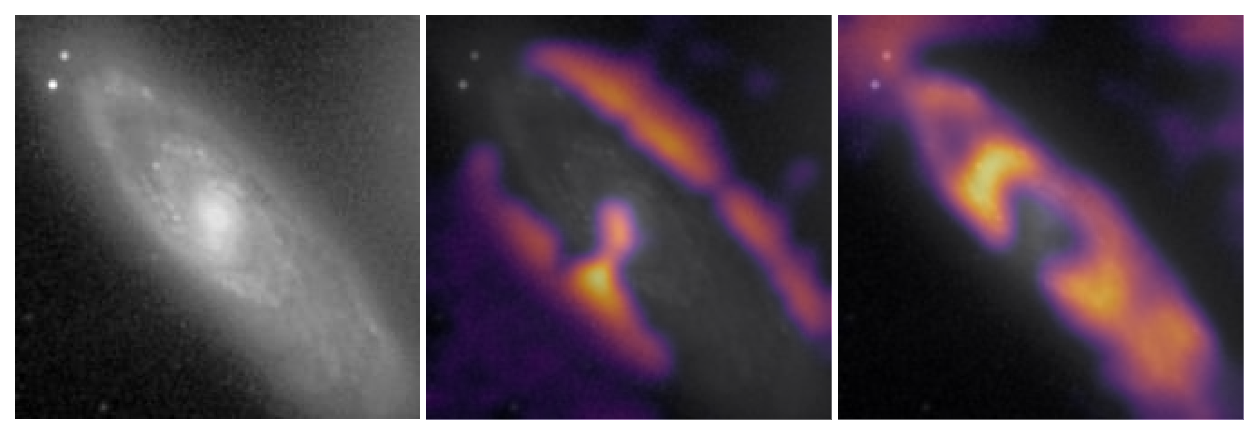

In [268]:
plot_gradcam(xb, 16)

tensor([[-1.5682,  1.6116]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-1.5682,  1.6116]], device='cuda:0', grad_fn=<AddmmBackward>)


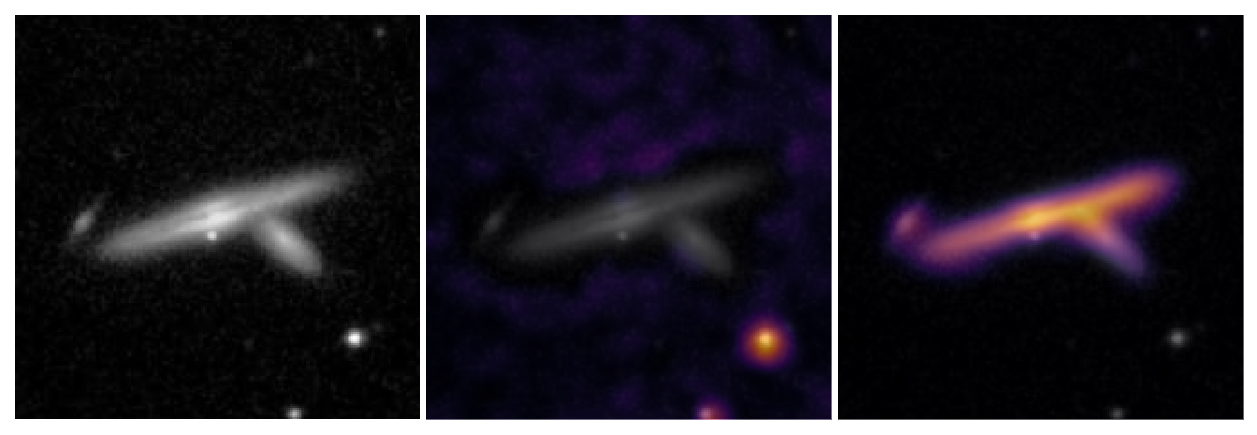

In [269]:
plot_gradcam(xb, 22)

tensor([[ 0.8533, -0.7536]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.8533, -0.7536]], device='cuda:0', grad_fn=<AddmmBackward>)


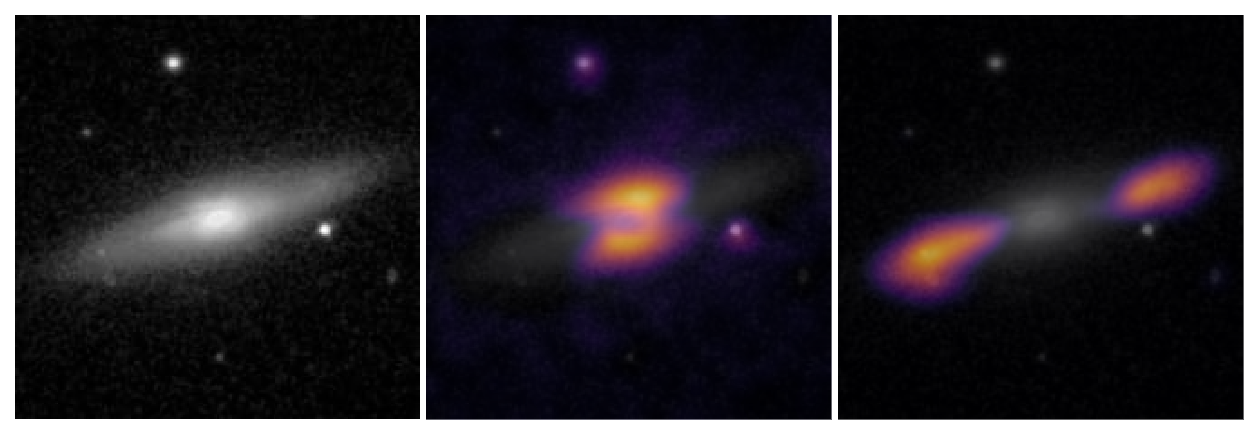

In [270]:
plot_gradcam(xb, 33)

tensor([[-7.4094,  7.8294]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-7.4094,  7.8294]], device='cuda:0', grad_fn=<AddmmBackward>)


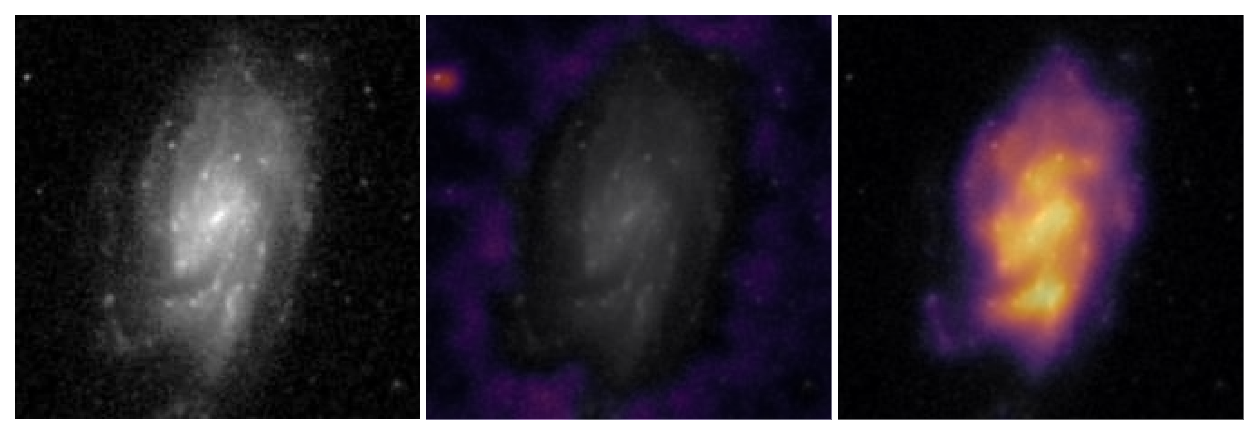

In [271]:
plot_gradcam(xb, 34)

tensor([[-3.8526,  4.1325]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.8526,  4.1325]], device='cuda:0', grad_fn=<AddmmBackward>)


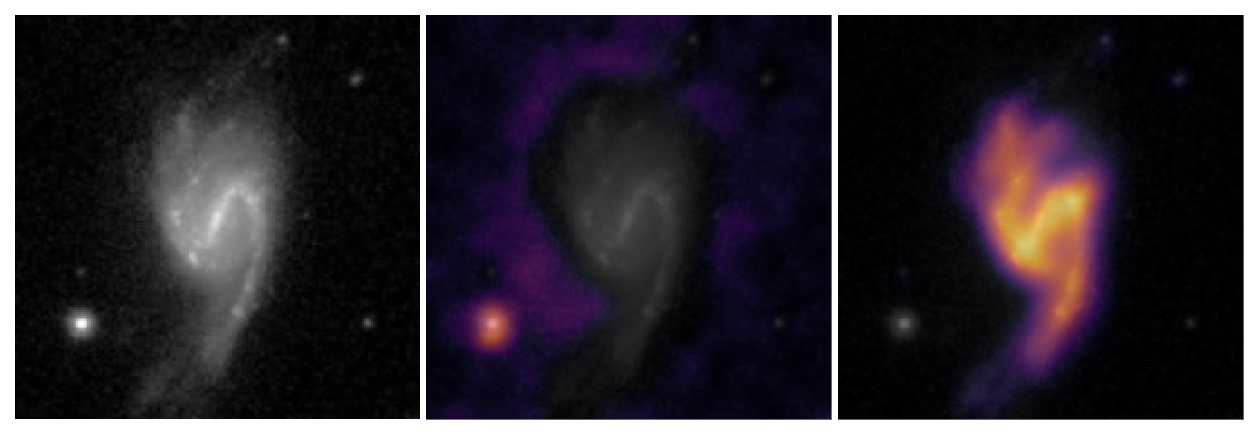

In [272]:
plot_gradcam(xb, 50)

tensor([[-2.4642,  2.5699]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.4642,  2.5699]], device='cuda:0', grad_fn=<AddmmBackward>)


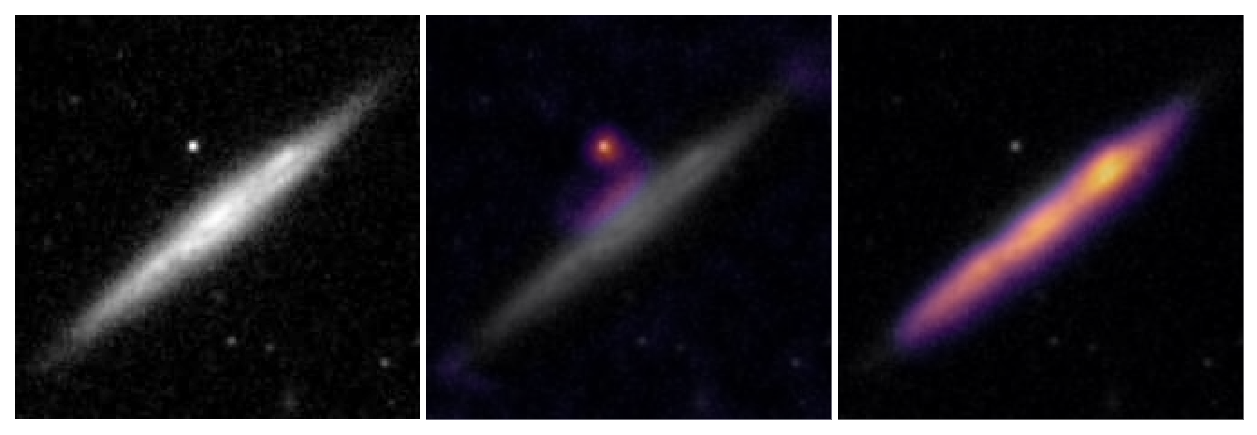

In [273]:
plot_gradcam(xb, 57)

tensor([[ 1.3300, -1.4489]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 1.3300, -1.4489]], device='cuda:0', grad_fn=<AddmmBackward>)


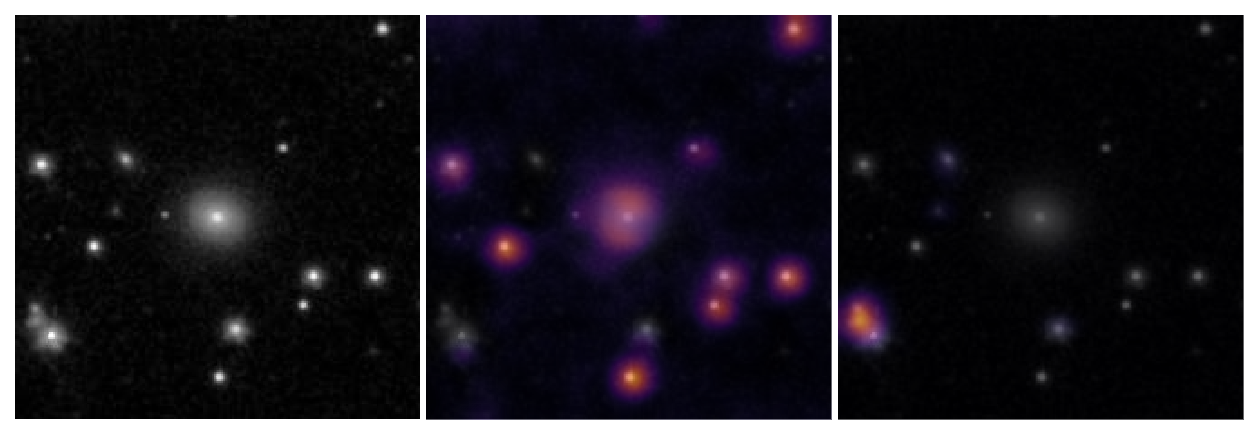

In [274]:
plot_gradcam(xb, 60)

tensor([[ 0.2772, -0.2933]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.2772, -0.2933]], device='cuda:0', grad_fn=<AddmmBackward>)


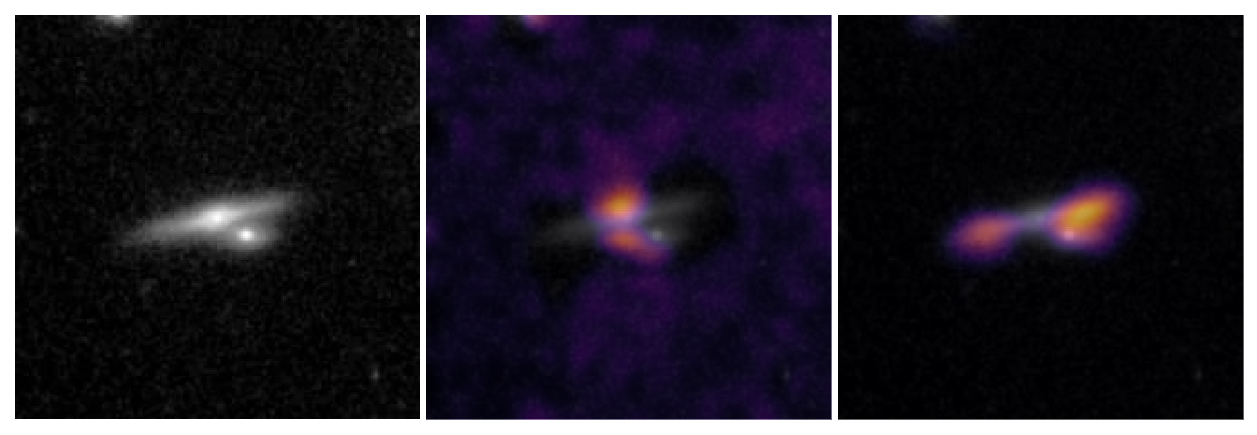

In [275]:
plot_gradcam(xb, 61)

# Repeat with ALFALFA

In [277]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
df = df[(df.logfgas > 0.5) | (df.logfgas < -.5)]

df['gas_rich'] = np.where(df.logfgas > -0.5, True, False)

In [278]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['gas_rich'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [284]:
model = XResNet(ResBlock, 1, [2,2], c_in=1, n_out=2, stem_szs=[16, 32, 64])
model[-1] = nn.Linear(in_features=128, out_features=2)
learn = Learner(
    dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.2089296132326126)

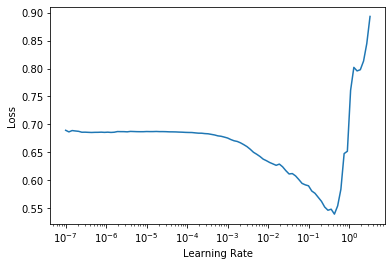

In [282]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 1e-2)

KeyboardInterrupt: 

## Examine results